In [19]:
# Import necessary libraries
import sys
import os
import pandas as pd

# Add the src directory to the system path to import modules
sys.path.append(os.path.abspath('..'))

from src.data_loader import DataLoader
from src.text_vectorization import TextVectorizer
from src.dataset_preparation import DatasetPreparation
from src.toxicity_pipeline import ToxicityAnalysisPipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# Step 1: Initialize the pipeline with data file path
data_file = '../data/train.csv.zip'
pipeline = ToxicityAnalysisPipeline(data_file)

# Step 2: Run the pipeline to get datasets
train_ds, val_ds, test_ds = pipeline.run()

In [77]:
# Define constants
MAX_WORDS = 200_000  # Adjust this based on your vocabulary size
EMBEDDING_DIM = 32   # Dimension of the embedding layer
LSTM_UNITS = 32      # Number of LSTM units
DENSE_UNITS = [128, 256, 128]  # Units for the fully connected layers
OUTPUT_CLASSES = 6   # Number of output classes

# Initialize the Sequential model
tox_model = Sequential()

# Create the embedding layer
tox_model.add(Embedding(input_dim=MAX_WORDS + 1, output_dim=EMBEDDING_DIM))

# Add Bidirectional LSTM Layer with dropout for regularization
tox_model.add(Bidirectional(LSTM(LSTM_UNITS, activation='tanh', return_sequences=False)))
tox_model.add(Dropout(0.5))  # Dropout layer to prevent overfitting

# Add fully connected layers with dropout for regularization
for units in DENSE_UNITS:
    tox_model.add(Dense(units, activation='relu'))
    tox_model.add(Dropout(0.5))  # Dropout layer after each dense layer

# Final output layer with sigmoid activation for multi-label classification
tox_model.add(Dense(OUTPUT_CLASSES, activation='sigmoid'))

# Compile the model (specify optimizer and loss function)
tox_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
tox_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [78]:
# Define callbacks for better training management
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Stop training if no improvement after 3 epochs
    restore_best_weights=True  # Restore weights from the best epoch
)

model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Change to .keras extension
    monitor='val_loss',            # Monitor validation loss
    save_best_only=True,           # Save only the best model
    mode='min'                     # Minimize the validation loss
)

# Fit the model with additional options
history = tox_model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping, model_checkpoint],  # Include callbacks for better training control
    verbose=1  # Verbosity mode: 0 = silent, 1 = progress bar, 2 = one line per epoch
)

Epoch 1/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 3815s 546ms/step - accuracy: 0.8624 - loss: 0.0991 - val_accuracy: 0.9944 - val_loss: 0.0484
Epoch 2/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 3537s 507ms/step - accuracy: 0.9868 - loss: 0.0514 - val_accuracy: 0.9940 - val_loss: 0.0423
Epoch 3/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 3614s 518ms/step - accuracy: 0.9848 - loss: 0.0464 - val_accuracy: 0.9945 - val_loss: 0.0427
Epoch 4/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 3573s 512ms/step - accuracy: 0.9927 - loss: 0.0427 - val_accuracy: 0.9942 - val_loss: 0.0384
Epoch 5/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 3594s 515ms/step - accuracy: 0.9927 - loss: 0.0397 - val_accuracy: 0.9944 - val_loss: 0.0397
Epoch 6/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 3509s 503ms/step - accuracy: 0.9898 - loss: 0.0388 - val_accuracy: 0.9949 - val_loss: 0.0363
Epoch 7/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 3517s 504ms/step - accuracy: 0.9926 - loss: 0.0375 - val_accuracy: 0.9934 - val_loss: 0.0358
Epoch 8/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 3530s 506ms/s

In [79]:
# Save the model in .keras format
tox_model.save('modelo_toxic_2024_10_26.keras')


In [14]:
# Save the model in .keras format
model.save('modelo_2024_10_24.keras')


In [80]:
history.history

{'accuracy': [0.9472765326499939,
  0.9887372851371765,
  0.9860514402389526,
  0.9931331276893616,
  0.9919871687889099,
  0.9921751618385315,
  0.9933838248252869,
  0.9918349981307983,
  0.9882717132568359,
  0.9873406291007996],
 'loss': [0.07202334702014923,
  0.0512564592063427,
  0.046999480575323105,
  0.043543100357055664,
  0.041568830609321594,
  0.03876316919922829,
  0.03752865642309189,
  0.036260105669498444,
  0.03511132672429085,
  0.03450988605618477],
 'val_accuracy': [0.9944207668304443,
  0.9940446615219116,
  0.9944521188735962,
  0.9942013621330261,
  0.9943580627441406,
  0.9948909282684326,
  0.9933550357818604,
  0.9938879013061523,
  0.9939192533493042,
  0.9945774674415588],
 'val_loss': [0.04837600141763687,
  0.042343735694885254,
  0.04266571253538132,
  0.038443416357040405,
  0.039716936647892,
  0.03625505045056343,
  0.035841505974531174,
  0.034676603972911835,
  0.03252170979976654,
  0.03321671858429909]}

In [81]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

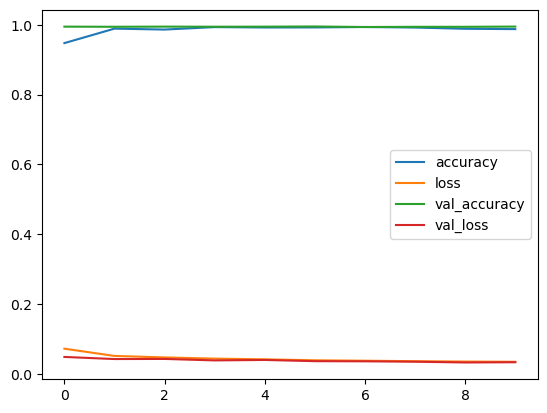

In [82]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show();

### Make Predictions


In [83]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np

from tensorflow.keras.layers import TextVectorization

df = pd.read_csv('/Users/rafaeloliveira/code/Github Repos/mlops_comment_toxicity/data/train.csv.zip')

X = df['comment_text']
y = df[df.columns[2:]].values

MAX_WORDS = 200_000

vectorizer = TextVectorization(max_tokens=MAX_WORDS,
                               output_sequence_length=1800,
                               output_mode='int')

vectorizer.adapt(X.values)

vectorized_text = vectorizer(X.values)

dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160_000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [84]:
batch = test.as_numpy_iterator().next()

In [85]:
input_text = vectorizer('You freaking suck! I am going to hit you!')

In [86]:
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   7, 7158,  397, ...,    0,    0,    0])>

In [87]:
batch = test_ds.as_numpy_iterator().next()

In [88]:
batch_X, batch_y = test_ds.as_numpy_iterator().next()

In [89]:
(tox_model.predict(batch_X) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [90]:
np.expand_dims(input_text, 0)

array([[   7, 7158,  397, ...,    0,    0,    0]])

In [107]:
tox_model.predict(np.expand_dims(input_text, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


array([[0.9288564 , 0.12171406, 0.74573326, 0.0648867 , 0.6046544 ,
        0.11940768]], dtype=float32)

In [92]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [93]:
res = tox_model.predict(np.expand_dims(input_text, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


### Validação


In [41]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [94]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [95]:
for batch in test_ds.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make prediction
    yhat = tox_model.predict(X_true)

    # Flaatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━

2024-10-27 18:49:06.447874: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [108]:
tox_model.save('toxicity_2024_10_29.keras')

In [110]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [109]:
model = tf.keras.models.load_model('toxicity_2024_10_29.keras')

In [55]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.8748428225517273, Recall: 0.7368420958518982, Accuracy: 0.5065065026283264


In [59]:
!pip uninstall gradio fastapi pydantic typing-extensions -y


Found existing installation: gradio 5.4.0
Uninstalling gradio-5.4.0:
  Successfully uninstalled gradio-5.4.0
Found existing installation: fastapi 0.115.3
Uninstalling fastapi-0.115.3:
  Successfully uninstalled fastapi-0.115.3
Found existing installation: pydantic 2.9.2
Uninstalling pydantic-2.9.2:
  Successfully uninstalled pydantic-2.9.2
Found existing installation: typing_extensions 4.12.2
Uninstalling typing_extensions-4.12.2:
  Successfully uninstalled typing_extensions-4.12.2


In [103]:
!pip install fastapi==0.103.2

  Obtaining dependency information for typing-extensions>=4.5.0 from https://files.pythonhosted.org/packages/26/9f/ad63fc0248c5379346306f8668cda6e2e2e9c95e01216d2b8ffd9ff037d0/typing_extensions-4.12.2-py3-none-any.whl.metadata
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.5.1 requires pydantic<2,>=1.8.1, but you have pydantic 2.9.2 which is incompatible.
dataprep 0.4.1 requires pydantic<2.0,>=1.6, but you have pydantic 2.9.2 which is incompatible.


In [102]:
!pip uninstall gradio typing-extensions -y

Found existing installation: gradio 5.4.0
Uninstalling gradio-5.4.0:
  Successfully uninstalled gradio-5.4.0
Found existing installation: typing_extensions 4.12.2
Uninstalling typing_extensions-4.12.2:
  Successfully uninstalled typing_extensions-4.12.2


In [105]:
!pip install gradio

  Obtaining dependency information for gradio from https://files.pythonhosted.org/packages/a5/ba/18ad189474e730baa47697c55afd4ab7c0d19d429232f7b8f771f3fd76d5/gradio-5.4.0-py3-none-any.whl.metadata
  Using cached gradio-5.4.0-py3-none-any.whl.metadata (16 kB)
  Obtaining dependency information for fastapi<1.0,>=0.115.2 from https://files.pythonhosted.org/packages/57/95/4c5b79e7ca1f7b372d16a32cad7c9cc6c3c899200bed8f45739f4415cfae/fastapi-0.115.3-py3-none-any.whl.metadata
  Using cached fastapi-0.115.3-py3-none-any.whl.metadata (27 kB)
  Obtaining dependency information for starlette<1.0,>=0.40.0 from https://files.pythonhosted.org/packages/54/43/f185bfd0ca1d213beb4293bed51d92254df23d8ceaf6c0e17146d508a776/starlette-0.41.2-py3-none-any.whl.metadata
Using cached gradio-5.4.0-py3-none-any.whl (56.7 MB)
Using cached fastapi-0.115.3-py3-none-any.whl (94 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 1.7 MB/s eta 0:00:0000:01
  Attempting uninstall: starlette
    Found existing i

In [106]:
import gradio as gr

ImportError: cannot import name 'Doc' from 'typing_extensions' (/opt/homebrew/Caskroom/miniforge/base/envs/env_mba_ufscar/lib/python3.11/site-packages/typing_extensions.py)

In [76]:
from typing_extensions import Doc

ImportError: cannot import name 'Doc' from 'typing_extensions' (/opt/homebrew/Caskroom/miniforge/base/envs/env_mba_ufscar/lib/python3.11/site-packages/typing_extensions.py)

In [74]:
!pip install --upgrade typing-extensions